# Figures for the paper

Idea is not to get 100% in any of these categories, just show the possiibilites with a single model. 


0. There exists a mapping 
    - Using encoder to generate profiles
    - Plot of latent space

1. Comparing to JET PDB 
    - MTANH fit for pedestal parameters 
    - Compare fit results to that in JET PDB 
    - Should over/under estimate
2. Behaviour in variations of machine parameters
    - Linear in $I_P$
    - $P_{NBI}$ Small effects 
    - See Frassinetti 2020 for more details on waht to expect
3. Comparison of similar pulses
    - Predictions on MPs and Other 
    - Interpolation? 
    - Latent space location ?
4. Error bars
    - Sample repeatedly for a given MP and see in Data space the variation, this is the errors in the estimate. 

Things to keep in mind: 
- Is what we add to the model useful? This being the physics. 

In [66]:
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
import torch 
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from torch.nn import functional as F
from scipy.optimize import curve_fit
from IPython.display import display, HTML
from moxie.models.DIVA_ak_2 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK
from moxie.data.utils_ import load_data, standardize, de_standardize, normalize_profiles
from moxie.models.utils_ import conditional_inference_simple_mean
import warnings
import scipy.stats
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [2]:
# Load data 
train_data, val_data, test_data = load_data(dataset_choice='SANDBOX_NO_VARIATIONS', file_loc='/home/adam/ENR_Sven/moxie/data/processed/pedestal_profiles_ML_READY_ak_4052022_uncerts.pickle')
(train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids, train_uncert), (val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids, val_uncert), (test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids, test_uncert) = train_data, val_data, test_data

machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
JET_PDB = pd.read_csv('/home/adam/ENR_Sven/moxie/data/raw/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
FLAGS = [x for x in JET_PDB.columns.to_list() if 'FLAG' in x]

In [14]:
# Load model 
model_hyperparams_physics = {'in_ch': 2, 'out_length':19,
                    'mach_latent_dim': 9, 'stoch_latent_dim': 3,
                    'beta_stoch': 1.0, 'beta_mach_unsup':  0.001,'beta_mach_sup':  0.0,
                    'alpha_mach': 1.0, 'alpha_prof': 20.0,  # 212, 306, 26, 295, 263, 336] 	[485, 499, 352, 432]
                    'start_sup_time': 1000,
                    'physics': False, 'gamma_stored_energy': 1.0, 'gamma_bpol': 1.0, 'gamma_beta': 1.0, 
                    'mp_hdims_aux': [64, 32], 'mp_hdims_cond':[64, 32], # 'mp_hdims_aux': [263, 469, 284], 'mp_hdims_cond':[20, 136, 54, 205, 154, 408], # 'mp_hdims_cond': [397, 369, 29, 113, 284], 'mp_hdims_aux': [122, 398, 463, 354, 399], 
                    'hidden_dims': [2, 4], 'loss_type': 'semi-supervised',}
model_physics = DIVAMODEL(**model_hyperparams_physics)
model_name_physics = 'modelstatedict_SECULAR_semi-supervised-cutoffLOSS_9MD_3SD_0BMUN_15.0BMSUP_5.0BS_500AM_379AP_50EP' # Helsinki desktop example
model_name_physics = 'modelstatedict_SCHEDULER_PHYSICS_9MD_3SD_0BMUN_10.0BMSUP_1.5BS_500AM_960AP_50EP_100.0GAMMA' # Home Laptop Example
state_dict = torch.load('../Find_optimal_model/model_results/{}.pth'.format(model_name_physics))
model_physics.load_state_dict(state_dict['model'])

# Convert things to tensors 
norms_MP, norms_D, norms_T = state_dict['MP_norms'], state_dict['D_norms'], state_dict['T_norms']
MP_norm, MP_var = norms_MP
D_norm, D_var = norms_D
T_norm, T_var = norms_T


all_masks = np.vstack((train_mask, val_mask, test_mask)) > 0
all_psis = np.vstack((train_radii, val_radii, test_radii))
all_rmids = np.vstack((train_real_space_radii, val_real_space_radii, test_real_space_radii))

# Training Tensors 

train_mp_tensors = torch.tensor(train_y).float()
val_mp_tensors = torch.tensor(val_y).float()
test_mp_tensors = torch.tensor(test_y).float()
all_mp_tensors = torch.vstack((train_mp_tensors, val_mp_tensors, test_mp_tensors))


train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
val_mp_normalized = standardize(val_mp_tensors, MP_norm, MP_var)
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X).float()
val_profiles = torch.tensor(val_X).float()
test_profiles = torch.tensor(test_X).float()
all_profiles = torch.vstack((train_profiles, val_profiles, test_profiles))

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized = normalize_profiles(train_profiles_normalized, T_norm, T_var, D_norm, D_var)

val_profiles_normalized = torch.clone(val_profiles).float()
val_profiles_normalized = normalize_profiles(val_profiles_normalized, T_norm, T_var, D_norm, D_var)

test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized = normalize_profiles(test_profiles_normalized, T_norm, T_var, D_norm, D_var)

# Ordering and pulse ids

train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses = list(set(train_pulse_order))
train_pulse_idxs = [[index for index in range(len(train_pulse_order)) if train_pulse_order[index] == pulse] for pulse in train_pulses]

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses = list(set(val_pulse_order))
val_pulse_idxs = [[index for index in range(len(val_pulse_order)) if val_pulse_order[index] == pulse] for pulse in val_pulses]

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses = list(set(test_pulse_order))
test_pulse_idxs = [[index for index in range(len(test_pulse_order)) if test_pulse_order[index] == pulse] for pulse in test_pulses]

all_pulse_order = train_pulse_order + val_pulse_order + test_pulse_order 
all_pulses = list(set(all_pulse_order))
all_pulse_idxs = [[index for index in range(len(all_pulse_order)) if all_pulse_order[index] == pulse] for pulse in all_pulses]


In [4]:
print(train_uncert)

[[[3.25995439e+18 5.20830302e+18 5.82674257e+18 ... 2.71353340e+18
   3.64818205e+18 1.12065227e+19]
  [6.37250671e+01 7.58151474e+01 8.10265732e+01 ... 4.40067688e+02
   3.88090918e+03 1.22038383e+02]]

 [[3.27913263e+18 5.00275921e+18 5.78018375e+18 ... 3.15066101e+18
   1.00437476e+20 1.00437476e+20]
  [6.15678635e+01 7.39633560e+01 8.35112000e+01 ... 1.54719434e+03
   1.00000002e+20 1.00000002e+20]]

 [[5.21598311e+18 5.21598311e+18 5.75860034e+18 ... 3.58593046e+18
   3.92014406e+18 1.00437476e+20]
  [9.24812698e+01 9.24812698e+01 7.63124771e+01 ... 1.90466968e+03
   1.49584814e+04 1.00000002e+20]]

 ...

 [[3.78274331e+18 3.78274331e+18 5.50961758e+18 ... 9.31987573e+19
   9.31987573e+19 6.68073367e+17]
  [7.74532166e+01 7.74532166e+01 1.13965599e+02 ... 1.00000002e+20
   1.00000002e+20 2.21768341e+02]]

 [[3.34765007e+18 3.34765007e+18 5.73019556e+18 ... 9.31987573e+19
   9.31987573e+19 9.31987573e+19]
  [6.79948349e+01 6.79948349e+01 1.07546074e+02 ... 1.00000002e+20
   1.00000

In [70]:
def conditional_inference_simple_mean(PULSE, model=None): 
    X, PSI, MASK, ID, MPS, _, UNCERT = PULSE
    X[:, 0] = standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = standardize(X[:, 1], T_norm, T_var)
    MPS = standardize(MPS, MP_norm, MP_var)
    with torch.no_grad():         
        cond_mu, cond_var =  model.p_zmachx(MPS)
        z_mach = model.reparameterize(cond_mu, cond_var)
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X)
        z_stoch = mu_stoch
        z_mach = cond_mu
        z_conditional = torch.cat((z_stoch, z_mach), 1)
        out_profs_cond = model.p_yhatz(z_conditional)
    out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_norm, D_var)
    out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_norm, T_var)
    MPS = de_standardize(MPS, MP_norm, MP_var)
    X[:, 0] = de_standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = de_standardize(X[:, 1], T_norm, T_var)
    return out_profs_cond

# 1) Compare with JET PDB 

In [15]:

def mtanh(r_vals, h1, h0, p, w, s):
    x = (p-r_vals) / (w/2.0)
    return (h1/2.0 - h0/2.0)*((((1+s*x)*np.exp(x)) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0
    
def calculate_ped_params_from_fit(PROFILES, profiles_predictions, pedestal_database): 
    """
    A very shitty function that returns the pedestal fit parameters for a single pulse (multiple time slices). 
    If the fit fails to be found, it returns an nan for all fit params in conditional or experimental for the given time slice it failed on
    
    Parameters
    ----------
    
    PROFILES: profiles_real, radii, masks, ids, mps, real_radii
    
    profiles_predictions: the conditional generated profiles, with obviously same shape as profiles_real
    
    Returns
    ----------
    
    cond_pred_fit_params, real_fit_params, (ne_jetpbd, te_jetpdb, pe_jetpdb): np.array((3, 5, len(profiles))), np.array((3, 5, len(profiles))), (np.array(5), np.array(5), np.array(5))
        i.) Conditional fit params for all time slices in pulse, ii) experrimetnal fit params for all slices in pulse iii) tuple with the 
        fit param arrays look like this: 
        [ ne[height (10^-19 m^-3), offset(-), position(m), width(m), slope(-)], 
          te[height (keV), offset(-), position(m), width(m), slope(-)], 
          pe[height (kPa), offset (-), position(m), width(m), slope(-)]
        ]

    The condiitonal fit params for pe height come out a factor of 2 less for some reason, 
    """
    profiles_real, radii, masks, ids, mps, real_radii = PROFILES 
    profiles_con = profiles_predictions
    # grab parameters from Jet PDB 
    JPDB_pulse = pedestal_database[pedestal_database['shot'] == ids]
    
    # h1, h0, p, w, s
    initial_guesses_ne = np.array([JPDB_pulse['nepedheight10^19(m^-3)'].values[0], 0.0,  JPDB_pulse['nepositionRmid(m)'].values[0],0.01*JPDB_pulse['NepedestalwidthRmid(cm)'].values[0],JPDB_pulse['neinnerslope'].values[0], ])
    initial_guesses_te = np.array([JPDB_pulse['Tepedheight(keV)'].values[0], 0.0,  JPDB_pulse['TepositionRmid(m)'].values[0],0.01*JPDB_pulse['TepedestalwidthRmid(cm)'].values[0],JPDB_pulse['Teinnerslope'].values[0], ])
    initial_guesses_pe = np.array([JPDB_pulse['pepedheight(kPa)'].values[0] / 2.0, 0.0,  JPDB_pulse['pepositionRmid(m)'].values[0],0.01*JPDB_pulse['pepedestalwidthRmid(cm)'].values[0],JPDB_pulse['peinnerslope'].values[0], ])
    
    cond_pred_fit_params, real_fit_params, = np.zeros((3, 5, len(profiles_con))), np.zeros((3, 5, len(profiles_con)))
    mean_cond_fit_params, mean_real_fit_params = np.zeros((3, 5)), np.zeros((3, 5))
    # conditional predictions
    d_profs_con, t_profs_con = profiles_con[:, 0, :], profiles_con[:, 1, :]
    d_profs_real, t_profs_real = profiles_real[:, 0, :], profiles_real[:, 1, :]
    
    mean_d_profs_con, mean_t_profs_con = torch.mean(1e-19*d_profs_con, 0), torch.mean(1e-3*t_profs_con, 0)
    mean_d_profs_real, mean_t_profs_real = torch.mean(1e-19*d_profs_real, 0), torch.mean(1e-3*t_profs_real, 0)
    mean_p_profs_con, mean_p_profs_real = mean_d_profs_con*mean_t_profs_con, mean_d_profs_real*mean_t_profs_real
    
    for n, (d_prof, t_prof, rad, mask, d_prof_real, t_prof_real) in enumerate(zip(d_profs_con, t_profs_con, real_radii, masks, d_profs_real, t_profs_real)):
        xdata = rad[mask]
        
        xdata_fit = np.linspace(3.7, 3.9, 50)
        ydata_d = d_prof[mask]*1e-19
        ydata_t = t_prof[mask] / 1000.0
        
        ydata_d_real = d_prof_real[mask]*1e-19
        ydata_t_real = t_prof_real[mask] / 1000.0

        try: 
            popt_d, pcov_d = curve_fit(mtanh, xdata, ydata_d, p0 = initial_guesses_ne, maxfev = 2000)
            popt_t, pcov_t = curve_fit(mtanh, xdata, ydata_t, p0 = initial_guesses_te, maxfev = 2000)
            popt_p, pcov_p = curve_fit(mtanh, xdata, ydata_t*ydata_d, p0 = initial_guesses_pe, maxfev = 2000)
            
        except RuntimeError as e: 
            popt_d, popt_t, popt_p = [np.nan]*5, [np.nan]*5, [np.nan]*5
            
        try: 
            popt_d_real, pcov_d_real = curve_fit(mtanh, xdata, ydata_d_real, p0 = initial_guesses_ne, maxfev = 2000)
            popt_t_real, pcov_t_real = curve_fit(mtanh, xdata, ydata_t_real, p0 = initial_guesses_te, maxfev = 2000)
            popt_p_real, pcov_p_real = curve_fit(mtanh, xdata, ydata_d_real*ydata_t_real, p0 = initial_guesses_pe, maxfev = 2000)
        
        except RuntimeError as e: 
            popt_d_real, popt_t_real, popt_p_real = [np.nan]*5, [np.nan]*5, [np.nan]*5
        
        cond_pred_fit_params[0, :, n] = popt_d
        cond_pred_fit_params[1, :, n] = popt_t
        cond_pred_fit_params[2, :, n] = popt_p
        
        real_fit_params[0, :, n] = popt_d_real
        real_fit_params[1, :, n] = popt_t_real
        real_fit_params[2, :, n] = popt_p_real
        
    initial_guesses_pe[0] = initial_guesses_pe[0]*2
    return cond_pred_fit_params, real_fit_params, np.vstack((initial_guesses_ne, initial_guesses_te, initial_guesses_pe))

import warnings
from tqdm.notebook import tqdm
def do_all_pulses(pedestal_database, pulse_ids, pulse_profiles, pulse_mask, pulse_mps, pulse_rmid, pulse_psi, pulses, model):
    """
    
    pedestal_database, pulse_rmid, pulse_psi
    
    Parameters
    ----------
    
    pulse_ids:
        is a list of lists, for each pulse, it denotes the locations of all time slices in that pulse 
        To get the list of indexes for the given pulse, access it via pulse_ids[0]
        To get the profiles for a given pulse you can then use: pulse_profiles[pulse_ids[0]]
    pulse_profiles: 
        All tensors for a given data subset (train-val-test)
    pulse_mask: 
        All mask tensors, to be accessed via > 0 
    pulses: int
        The actual pulse number 
    pulse_mps: 
        same as pulse_profiles but for hte machine parameters 
    
    Returns
    -------
    
    cond_pred_means: np.array((3, 5, # Pulses))
        For all pulses, the pedestal parameters from the conditional prior 
        This comes in the same row column format as pefore
        Accessing the ne height is then something like: 
        neped_conditional = cond_pred_means[0, 0, :]
    real_pred_means: np.array((3, 5, # Pulses))
    frass_means: np.array((3, 5, # Pulses))
    
    """
    iterator = tqdm(range(len(pulse_ids)))
    shot_list = pedestal_database['shot'].to_list()
        
    cond_pred_means, real_pred_means, frass_means = np.zeros((3, 5, len(pulse_ids))), np.zeros((3, 5, len(pulse_ids))), np.zeros((3, 5, len(pulse_ids)))
    cond_pred_stds, real_pred_stds = np.zeros((3, 5, len(pulse_ids))), np.zeros((3, 5, len(pulse_ids)))
    # rows: 0: ne, 1: te, 2: pe
    # cols: means: [height (10^-19 m^-3), offset(-), position(m), width(m), slope(-)], 
    # z dim is per pulse 
    
    for k in iterator: 
        iterator.set_postfix_str(str(pulses[k]))
        
        if pulses[k] not in shot_list: 
            # Set to NAN! 
            cond_pred_means[:, :, k], real_pred_means[:, :, k], frass_means[:, :, k] = np.zeros((3,5)) * np.nan, np.zeros((3,5)) * np.nan, np.zeros((3,5)) * np.nan 
            cond_pred_stds[:, :, k], real_pred_stds[:, :, k] = np.zeros((3,5)) * np.nan, np.zeros((3,5)) * np.nan 
            # neped_height_mean[k] = np.nan#  abs(filtered_pred_fit_params[0, :, :].mean(1))[0]
            continue           
        PULSE_sample = pulse_profiles[pulse_ids[k]], pulse_psi[pulse_ids[k]], pulse_mask[pulse_ids[k]] > 0, pulses[k], pulse_mps[pulse_ids[k]], pulse_rmid[pulse_ids[k]]
        PULSE_conditional = conditional_inference_simple_mean(PULSE_sample, model)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            cond_pred_fit_params, real_fit_params, frassineti = calculate_ped_params_from_fit(PULSE_sample, PULSE_conditional, pedestal_database)
            cond_pred_means[:, :, k], real_pred_means[:, :, k], frass_means[:, :, k] = np.mean(cond_pred_fit_params, 2), np.mean(real_fit_params, 2), frassineti
            cond_pred_stds[:, :, k], real_pred_stds[:, :, k] = np.std(cond_pred_fit_params, 2), np.std(real_fit_params, 2)
    return cond_pred_means, real_pred_means, frass_means, cond_pred_stds, real_pred_stds

def plot_ped_params_results(cond_pred_means, real_pred_means, frass_means):  
    params = ['Height', 'Position','Width', 'Slope']
    params_idx = [0, 2, 3, 4]
    lim_dict = {'Height': {'0': (1, 11), '1': (0, 1.3), '2': (0, 13)}, 
                'Position': {'0': (3.785, 3.865), '1': (3.785, 3.85), '2':(3.78, 3.85)}, 
               'Width': {'0': (None, None), '1': (None, None), '2':(None, None)}, 
               'Slope': {'0': (None, None), '1': (0, 0.6), '2':(0, 0.6)}}    
    
    for p, p_idx in zip(params, params_idx): 
        

        fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(13, 5))
        fig.suptitle(p)

        for i in [0, 1, 2]: 
            if p == 'Height' and i == 2: 
                scaling_factor = 2.0 
            else: 
                scaling_factor = 1.0
            axs[i].scatter(frass_means[i, p_idx, :], scaling_factor*cond_pred_means[i, p_idx, :])
            axs[i].plot([min(frass_means[i, p_idx, :]), max(frass_means[i, p_idx, :])],[min(frass_means[i, p_idx, :]), max(frass_means[i, p_idx, :])], 'k--')
            axs[i].set(ylim=lim_dict[p][str(i)], xlim=lim_dict[p][str(i)])   

def plot_all_sets_params_results(train_res, val_res, test_res, errors=False): 
    params = ['Height', 'Position (m)','Width (m)', 'Slope (-)']
    params_idx = [0, 2, 3, 4]
    lim_dict = {'Height': {'0': (1, 11), '1': (0, 1.3), '2': (0, 13)}, 
                'Position (m)': {'0': (3.785, 3.865), '1': (3.785, 3.85), '2':(3.78, 3.85)}, 
               'Width (m)': {'0': (None, None), '1': (None, None), '2':(None, None)}, 
               'Slope (-)': {'0': (None, None), '1': (0, 0.6), '2':(0, 0.6)}}    
    title = ['ne', 'te', 'pe']
    labels = ['Train', 'Valid', 'Test']
    for p, p_idx in zip(params, params_idx): 
        fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(13, 5))
        fig.suptitle(p)
        for n, data_set in enumerate([train_res, val_res, test_res]):
            cond_pred_means, _, frass_means, cond_pred_std, _ = data_set
            for i in [0, 1, 2]: 
                if p == 'Height' and i == 2: 
                    scaling_factor = 2.0 
                else: 
                    scaling_factor = 1.0
                axs[i].scatter(frass_means[i, p_idx, :], scaling_factor*cond_pred_means[i, p_idx, :], label=labels[n])
                if errors: 
                    axs[i].errorbar(frass_means[i, p_idx, :], scaling_factor*cond_pred_means[i, p_idx, :], yerr=cond_pred_std[i, p_idx, :], alpha=0.3, color='grey', fmt='none')
                if n == 0: 
                    axs[i].plot([min(frass_means[i, p_idx, :]), max(frass_means[i, p_idx, :])],[min(frass_means[i, p_idx, :]), max(frass_means[i, p_idx, :])], 'k--')
                    axs[i].set(ylim=lim_dict[p][str(i)], xlim=lim_dict[p][str(i)], title=title[i])   
            axs[0].legend()


train_res = do_all_pulses(JET_PDB, train_pulse_idxs, train_profiles, train_mask, train_mp_tensors, train_real_space_radii, train_radii, train_pulses, model=model_physics)
val_res = do_all_pulses(JET_PDB, val_pulse_idxs, val_profiles, val_mask, val_mp_tensors, val_real_space_radii, val_radii, val_pulses, model=model_physics)
test_res = do_all_pulses(JET_PDB, test_pulse_idxs, test_profiles, test_mask, test_mp_tensors, test_real_space_radii, test_radii, test_pulses, model=model_physics)



  0%|          | 0/533 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

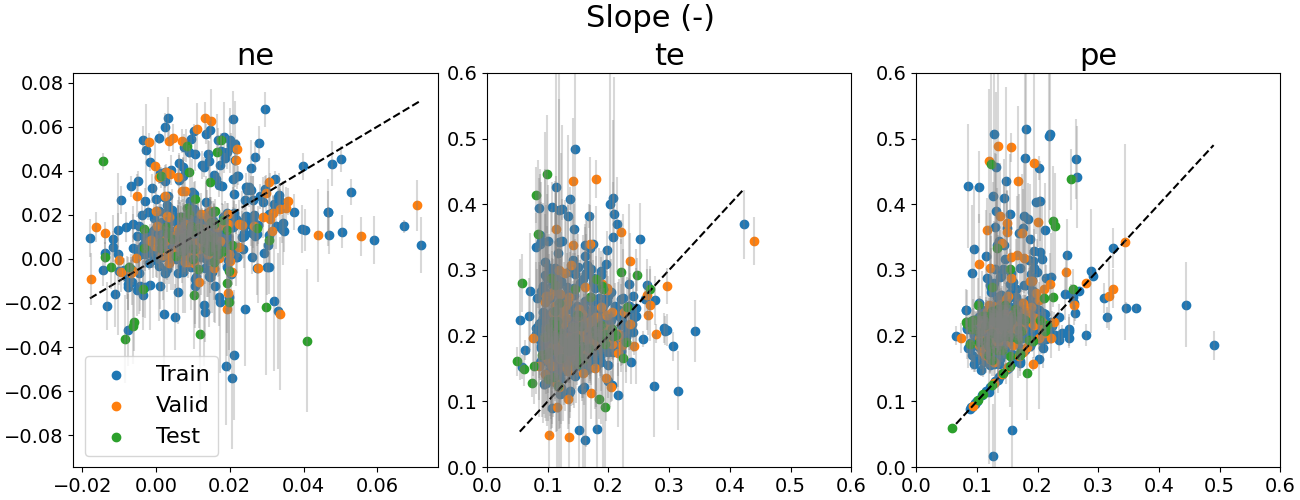

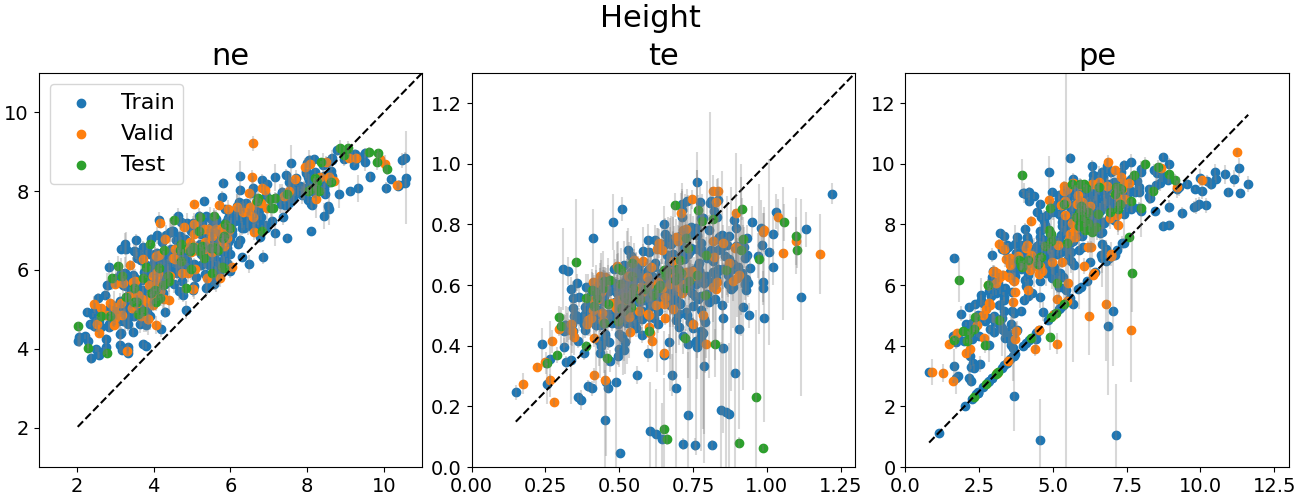

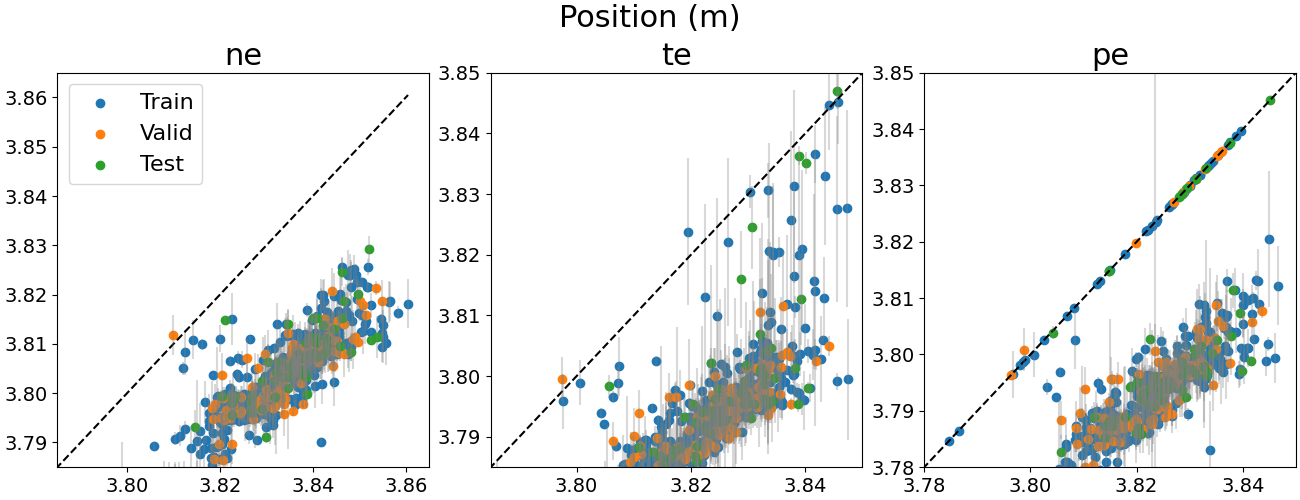

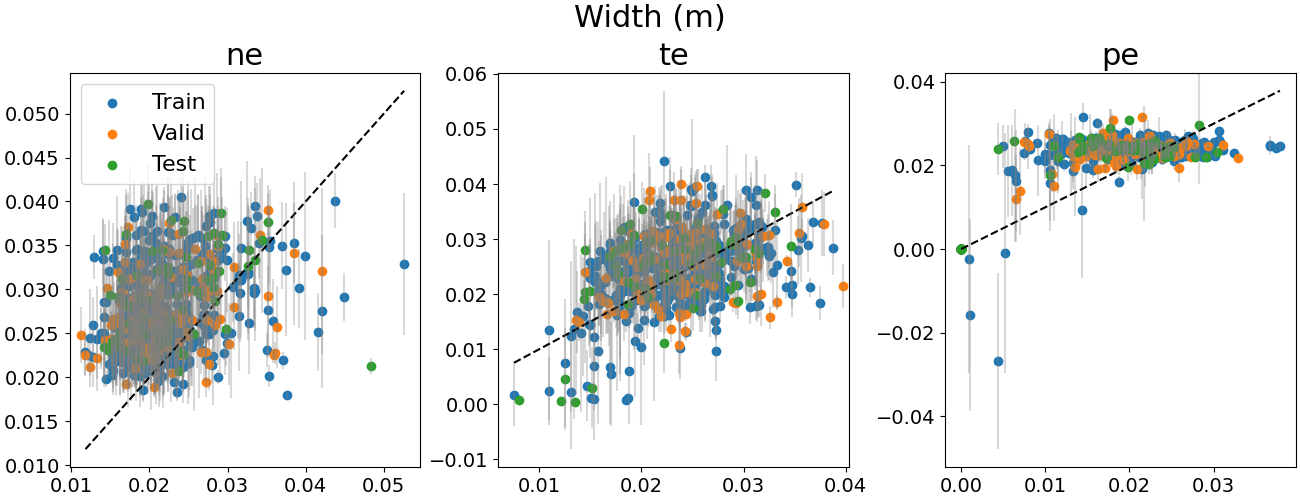

In [16]:
plt.close('all')
cond_pred_means_train, real_pred_means_train, frass_means_train, _, _= train_res
cond_pred_means_val, real_pred_means_val, frass_means_val, _, _ = val_res
cond_pred_means_test, real_pred_means_test, frass_means_test, _, _ = test_res
plot_all_sets_params_results(train_res, val_res, test_res, errors=True)
# plot_ped_params_results(cond_pred_means_val, real_pred_means_val, frass_means_val)
plt.show()

# 0) Find $n_{e, sep}$

In [ ]:
# train pulses! 
plt.close('all')
def plot_single_result(fit_params, real_pulse_stuff, cond_profiles, lorenzo_nesep, frass_params, nesep_info):
    real_profiles, _, real_masks, ID, _, real_radii = real_pulse_stuff
    lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    ne_lorenzo, te_lorenzo, pe_lorenzo = frass_params
    
    ne_params, te_params, pe_params = fit_params
    new_r = np.linspace(3.7, 3.9, 100) 
    fitted_te = mtanh(new_r, *te_params)
    fitted_ne = mtanh(new_r, *ne_params)
    
    te_sep_idx, nesep, nesep_prob, nesep_prob_std = nesep_info
    
    # te_sep_idx = find_te_sep(fitted_te)
    # nesep = find_ne_sep(fitted_ne, te_sep_idx)
    fig, axs = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    
    axs.annotate(text='pred nesep = {:.4}\nLorenzo nesep = {:.4}\nProb{:.4}'.format(nesep, lorenzo_nesep_fit, nesep_prob), xy=(0.01, 0.1), xycoords='axes fraction', fontsize='medium')
    
    axs.plot(new_r, mtanh(new_r, *te_params), color='orange',  label='$\hat{T}_e$ Pred. Fit')
    axs.tick_params(axis='y', labelcolor='orange')
    axs.set_ylabel('$T_e$ [keV]')
    axs.vlines(new_r[te_sep_idx], 0, 1)
    
    ax2 = axs.twinx()
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylabel('$n_e$ ($10^{19}$ m$^{-3}$)')
    ax2.plot(new_r, mtanh(new_r, *ne_params), color='blue',  label='$\hat{n}_e$ Pred. Fit')
    label_te = '$T_e$ real'
    label_ne = '$n_e$ real'
    
    for n, (d_prof, t_prof, real_rad, mask) in enumerate(zip(real_profiles[:, 0, :], real_profiles[:, 1, :], real_radii, real_masks)):
        if n > 0: 
            label_te, label_ne = None, None
        ax2.scatter(real_rad[mask], 1e-19*d_prof[mask], color='blue', alpha=0.1, label=label_ne)        
        axs.scatter(real_rad[mask], 1e-3*t_prof[mask], color='orange', alpha=0.1, label=label_te)
    ax2.legend()
    
    axs.legend(loc = 'center right')
    fig.suptitle(ID)
    plt.show()

    
def calculate_all_nesep(pedestal_database, pulse_ids, pulse_profiles, pulse_mask, pulse_mps, pulse_rmid, pulse_psi, pulses, model, cond_fits, frass_fits=None): 
    iterator = tqdm(range(len(pulse_ids)))
    # Store all, 0: prediction, 1: lorenzo from exp, 2: lorenzo from fit
    neseps_all = np.zeros((5, len(pulse_ids)))
    for k in iterator: 

        iterator.set_postfix_str(str(pulses[k]))
        PULSE_SAMPLE = pulse_profiles[pulse_ids[k]], pulse_psi[pulse_ids[k]], pulse_mask[pulse_ids[k]] > 0, pulses[k], pulse_mps[pulse_ids[k]], pulse_rmid[pulse_ids[k]]

        # PULSE_SAMPLE = train_profiles[train_pulse_idxs[k]], train_radii[train_pulse_idxs[k]], train_mask[train_pulse_idxs[k]] > 0, train_pulses[k], train_mp_tensors[train_pulse_idxs[k]], train_real_space_radii[train_pulse_idxs[k]], 
        PULSE_CONDITIONAL = conditional_inference_simple_mean(PULSE_SAMPLE, model)
        
        nesep_probabilistic, nesep_probabilistic_pred = find_nesep_probabilisticly(PULSE_SAMPLE, PULSE_CONDITIONAL)
        
        ne_params, te_params, pe_params  = cond_fits[:, :, k]
        # ne_lorenzo, te_lorenzo, pe_lorenzo = frass_fits[:, :, k]
        JPDB_pulse = JET_PDB[JET_PDB['shot'] == pulses[k]]
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
     
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep

        ne_params, te_params, pe_params = cond_fits[:, :, k]
        new_r = np.linspace(3.7, 3.9, 100) 
        fitted_te = mtanh(new_r, *te_params)
        fitted_ne = mtanh(new_r, *ne_params)

        te_sep_idx = find_te_sep(fitted_te)
        nesep = find_ne_sep(fitted_ne, te_sep_idx)
        nesep_info = (te_sep_idx, nesep, nesep_probabilistic.mean(), nesep_probabilistic.std())
        
        neseps_all[:, k] = [nesep, lorenzo_nesep_exp, lorenzo_nesep_fit, nesep_probabilistic_pred.mean(), nesep_probabilistic.mean()]
        
        # plot_single_result(cond_fits[:, :, k], PULSE_SAMPLE, PULSE_CONDITIONAL, lorenzo_nesep, frass_fits[:, :, k], nesep_info)
        
    return neseps_all

def find_ne_sep(fitted_ne, idx_tesep): 
    nearest_neighbors = fitted_ne[idx_tesep - 35:idx_tesep + 35]
    return np.mean(nearest_neighbors)
def find_te_sep(fitted_te):
    te_sep_idx = np.argmin(np.abs(fitted_te - 0.1))
    return te_sep_idx

def find_nesep_probabilisticly(PULSE_SAMPLE, PULSE_CONDITIONAL): 
    real_profiles, _, real_masks, ID, _, real_radii = PULSE_SAMPLE    
    nesep_approx = np.zeros(len(real_profiles))
    nesep_approx_pred = np.zeros(len(real_profiles))
    
    
    for n, (d_prof, t_prof, real_rad, mask, d_prof_cond, t_prof_cond) in enumerate(zip(real_profiles[:, 0, :], real_profiles[:, 1, :], real_radii, real_masks, PULSE_CONDITIONAL[:, 0, :], PULSE_CONDITIONAL[:, 1, :])):
        probabilities = np.exp(-(1e-3*t_prof[mask] - 0.1)**2) / (np.exp(-(1e-3*t_prof[mask] - 0.1)**2)).sum()
        guassians_te =  np.array([np.random.normal(mu, 0.2, 100) for mu in (1e-3*t_prof[mask])])
        guassians_ne =  np.array([np.random.normal(mu, 0.2, 100) for mu in (1e-19*d_prof[mask])])
        nesep_approx[n] = guassians_ne[np.logical_and(guassians_te < 0.12, guassians_te > 0.08)].mean()
        
        guassians_te =  np.array([np.random.normal(mu, 0.2, 100) for mu in (1e-3*t_prof_cond[mask])])
        guassians_ne =  np.array([np.random.normal(mu, 0.2, 100) for mu in (1e-19*d_prof_cond[mask])])
        nesep_approx_pred[n] = guassians_ne[np.logical_and(guassians_te < 0.12, guassians_te > 0.08)].mean()
        
        
    return nesep_approx, nesep_approx_pred

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_neseps = calculate_all_nesep(JET_PDB, train_pulse_idxs, train_profiles, train_mask, train_mp_tensors, train_real_space_radii, train_radii, train_pulses, model_physics, cond_pred_means_train, frass_means_train)
    val_neseps = calculate_all_nesep(JET_PDB, val_pulse_idxs, val_profiles, val_mask, val_mp_tensors, val_real_space_radii, val_radii, val_pulses, model_physics, cond_pred_means_val, frass_means_val)
    test_neseps = calculate_all_nesep(JET_PDB, test_pulse_idxs, test_profiles, test_mask, test_mp_tensors, test_real_space_radii, test_radii, test_pulses, model_physics, cond_pred_means_test, frass_means_test)

In [ ]:
plt.close('all')
def plot_results_nesep(train_results, val_results, test_results): 
    fig, axs = plt.subplots(2, 3, figsize=(12,8), constrained_layout=True, sharex='col', sharey='row')
    axs = axs.ravel()
    axs[0].set_ylabel('Fit Prediction')
    axs[0].scatter(train_results[1, :], train_results[0, :], label='Train')
    axs[0].scatter(val_results[1, :], val_results[0, :], label='Val')
    axs[0].scatter(test_results[1, :], test_results[0, :], label='Test')
    axs[0].plot(test_results[1, :],test_results[1, :], 'k--')
    axs[0].set_xlabel('Lorenzo from exp')
    
    axs[1].scatter(train_results[2, :], train_results[0, :], label='Train')
    axs[1].scatter(val_results[2, :], val_results[0, :], label='Val')
    axs[1].scatter(test_results[2, :], test_results[0, :], label='Test')
    axs[1].plot(test_results[2, :],test_results[2, :], 'k--')
    axs[1].legend()
    axs[1].set_xlabel('Lorenzo from fit')
    
    
    axs[2].scatter(train_results[4, :], train_results[0, :], label='Train')
    axs[2].scatter(val_results[4, :], val_results[0, :], label='Val')
    axs[2].scatter(test_results[4, :], test_results[0, :], label='Test')
    axs[2].plot(test_results[4, :],test_results[4, :], 'k--')
    axs[2].set_xlabel('From Gaussian')
    
    axs[3].set_ylabel('Guassian Prediction')
    axs[3].scatter(train_results[1, :], train_results[3, :], label='Train')
    axs[3].scatter(val_results[1, :], val_results[3, :], label='Val')
    axs[3].scatter(test_results[1, :], test_results[3, :], label='Test')
    axs[3].plot(test_results[1, :],test_results[1, :], 'k--')
    axs[3].set_xlabel('Lorenzo from exp')
    
    axs[4].scatter(train_results[2, :], train_results[3, :], label='Train')
    axs[4].scatter(val_results[2, :], val_results[3, :], label='Val')
    axs[4].scatter(test_results[2, :], test_results[3, :], label='Test')
    axs[4].plot(test_results[2, :],test_results[2, :], 'k--')
    axs[4].legend()
    axs[4].set_xlabel('Lorenzo from fit')
    
    
    axs[5].scatter(train_results[4, :], train_results[3, :], label='Train')
    axs[5].scatter(val_results[4, :], val_results[3, :], label='Val')
    axs[5].scatter(test_results[4, :], test_results[3, :], label='Test')
    axs[5].plot(test_results[4, :],test_results[4, :], 'k--')
    axs[5].set_xlabel('From Gaussian')
plot_results_nesep(train_neseps, val_neseps, test_neseps)

In [110]:
def calculate_all_nesep(pedestal_database, pulse_ids, pulse_profiles, pulse_mask, pulse_mps, pulse_rmid, pulse_psi, pulses, uncerts, model, cond_fits, frass_fits=None, sample_size=10000, var_static=0.7): 
    iterator = tqdm(range(len(pulse_ids)))
    # Store all, 0: prediction, 1: lorenzo from exp, 2: lorenzo from fit
    neseps_all = np.zeros((8, len(pulse_ids)))
    print(sample_size)
    for k in iterator: 
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulses[k]]
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
     
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
        
        # iterator.set_postfix_str(str(pulses[k]))
        PULSE_SAMPLE = pulse_profiles[pulse_ids[k]], pulse_psi[pulse_ids[k]], pulse_mask[pulse_ids[k]] > 0, pulses[k], pulse_mps[pulse_ids[k]], pulse_rmid[pulse_ids[k]], uncerts

        
        # PULSE_SAMPLE = train_profiles[train_pulse_idxs[k]], train_radii[train_pulse_idxs[k]], train_mask[train_pulse_idxs[k]] > 0, train_pulses[k], train_mp_tensors[train_pulse_idxs[k]], train_real_space_radii[train_pulse_idxs[k]], 
        PULSE_CONDITIONAL = conditional_inference_simple_mean(PULSE_SAMPLE, model)
        
        
        nesep_probabilistic, nesep_probabilistic_pred, nesep_mean, nesep_pred_mean = find_nesep_probabilisticly_2(PULSE_SAMPLE, PULSE_CONDITIONAL, sample_size, var_static)
        
        neseps_all[:, k] = np.array([lorenzo_nesep_exp, lorenzo_nesep_fit, nesep_probabilistic.mean(),nesep_probabilistic.std(), nesep_probabilistic_pred.mean(),nesep_probabilistic_pred.std(), nesep_mean, nesep_pred_mean])
        
        iterator.set_postfix_str(str(pulses[k]) + 'lor={:.2},einzel{:.2}pred{:.2}mean{:.2}'.format(lorenzo_nesep_exp,nesep_probabilistic.mean(), nesep_probabilistic_pred.mean(), nesep_mean))
        """
        print(f'\n---------------- PULSE {pulses[k]} ----------------')
        print('Frassinetti: exp = {:.4}, fit = {:.4}'.format(lorenzo_nesep_exp, lorenzo_nesep_fit))
        print('Prob. Method: approx = {:.4}, pred = {:.4}, L2 = {:.4}'.format(nesep_probabilistic.mean(), nesep_probabilistic_pred.mean(), (nesep_probabilistic.mean() - nesep_probabilistic_pred.mean())**2))
        print('w/o mask: approx = {:.4}, pred = {:.4}, L2 = {:.4}'.format(nesep_probabilistic_wo_mask.mean(), nesep_probabilistic_pred_wo_mask.mean(), (nesep_probabilistic_wo_mask.mean() - nesep_probabilistic_pred_wo_mask.mean())**2))
        L_2 = (nesep_probabilistic.mean() - lorenzo_nesep_exp)**2
        L_1 = (nesep_probabilistic.mean() - lorenzo_nesep_exp)
        print('\nL2 Norm (Frass_exp, mask_approx) = {:.4}, L1 = {:.4}'.format(L_2, L_1))
        L_2 = (nesep_probabilistic_wo_mask.mean() - lorenzo_nesep_exp)**2
        L_1 = (nesep_probabilistic_wo_mask.mean() - lorenzo_nesep_exp)
        print('L2 Norm (Frass_exp, womask_approx) = {:.4}, L1 = {:.4}'.format(L_2, L_1))
        """
    return neseps_all
    
def find_nesep_probabilisticly_2(PULSE_SAMPLE, PULSE_CONDITIONAL, sample_size=100, var_static=0.5, t_lims = (0.12, 0.08)): 
    real_profiles, _, real_masks, ID, _, real_radii, uncerts = PULSE_SAMPLE    
    nesep_approx = np.zeros(len(real_profiles))
    nesep_approx_pred = np.zeros(len(real_profiles))
    
    
    # without_mask_approx
    d_prof_mean, t_prof_mean = torch.mean(real_profiles[:, 0, :], 0), torch.mean(real_profiles[:, 1, :],0)
    dne_prof_mean, dte_prof_mean = np.mean(uncerts[:, 0, :], 0), np.clip(np.mean(uncerts[:, 1, :],0), a_min=None, a_max=5000)
    d_prof_cond_mean, t_prof_cond_mean = torch.mean(PULSE_CONDITIONAL[:, 0, :], 0), torch.mean(PULSE_CONDITIONAL[:, 1, :],0)
    
    # print(d_prof_mean, 1e-3*t_prof_mean)
    # print(dte_prof_mean*1e-3, t_prof_mean*1e-3)
    guassians_te =  np.array([np.random.normal(mu, var, sample_size) for mu, var in zip(1e-3*t_prof_mean, 1e-3*dte_prof_mean)])
    guassians_ne =  np.array([np.random.normal(mu, var, sample_size) for mu, var in zip(1e-19*d_prof_mean, 1e-19*dne_prof_mean)])
        
    nesep_mean = guassians_ne[np.logical_and(guassians_te < 0.12, guassians_te > 0.08)].mean()
    
    guassians_te =  np.array([np.random.normal(mu, var, sample_size) for mu, var in zip(1e-3*t_prof_cond_mean, [0.5]*len(d_prof_cond_mean))])
    guassians_ne =  np.array([np.random.normal(mu, var, sample_size) for mu, var in zip(1e-19*d_prof_cond_mean, [0.5]*len(d_prof_cond_mean))])
    nesep_pred_mean = guassians_ne[np.logical_and(guassians_te < 0.12, guassians_te > 0.08)].mean()
    
    
    
    for n, (d_prof, t_prof, real_rad, mask, d_prof_cond, t_prof_cond, dn_uncert, dt_uncert) in enumerate(zip(real_profiles[:, 0, :], real_profiles[:, 1, :], real_radii, real_masks, PULSE_CONDITIONAL[:, 0, :], PULSE_CONDITIONAL[:, 1, :], uncerts[:, 0, :], np.clip(uncerts[:, 1, :], a_min=0, a_max=10000))):
        guassians_te =  np.array([np.random.normal(mu, var, sample_size) for mu, var in zip(1e-3*t_prof, dt_uncert*1e-3)])
        guassians_ne =  np.array([np.random.normal(mu, var, sample_size) for mu, var in zip(1e-19*d_prof, 1e-19*dn_uncert)])
        nesep_approx[n] = guassians_ne[np.logical_and(guassians_te < 0.12, guassians_te > 0.08)].mean()
    
        guassians_te =  np.array([np.random.normal(mu, var_static, sample_size) for mu in (1e-3*t_prof_cond)])
        guassians_ne =  np.array([np.random.normal(mu, var_static, sample_size) for mu in (1e-19*d_prof_cond)])
        nesep_approx_pred[n] = guassians_ne[np.logical_and(guassians_te < 0.12, guassians_te > 0.08)].mean()
        
    return nesep_approx, nesep_approx_pred, nesep_mean, nesep_pred_mean

neseps_training = calculate_all_nesep(PULSE_DF_SANDBOX, train_pulse_idxs, train_profiles, train_mask, train_mp_tensors, train_real_space_radii, train_radii, train_pulses, train_uncert, model_physics, cond_pred_means_train, frass_means_train, 
                                      sample_size=10000, var_static=0.5)
val_neseps = calculate_all_nesep(JET_PDB, val_pulse_idxs, val_profiles, val_mask, val_mp_tensors, val_real_space_radii, val_radii, val_pulses, val_uncert, model_physics, cond_pred_means_val, frass_means_val, 
                                 sample_size=10000, var_static=0.5)
test_neseps = calculate_all_nesep(JET_PDB, test_pulse_idxs, test_profiles, test_mask, test_mp_tensors, test_real_space_radii, test_radii, test_pulses, test_uncert, model_physics, cond_pred_means_test, frass_means_test,
                                  sample_size=10000, var_static=0.5)
    

  0%|          | 0/533 [00:00<?, ?it/s]

5000


  0%|          | 0/130 [00:00<?, ?it/s]

5000


  0%|          | 0/80 [00:00<?, ?it/s]

5000


In [115]:
plt.close('all')
# [lor_exp, lor_fit, nesep_mask, nesep_pred_mask, nesep_wo_mask, nesep_wo_mask_pred]

names_list = ['lor_exp', 'lor_fit', 'mask', 'pred_mask', 'mean', 'pred_mean']
df_train = pd.DataFrame.from_dict(dict(zip(names_list, neseps_training)))  
df_val = pd.DataFrame.from_dict(dict(zip(names_list, val_neseps)))  
df_test = pd.DataFrame.from_dict(dict(zip(names_list, test_neseps)))  
import seaborn as sns
# plot_results_nesep(neseps_training, val_neseps, test_neseps)

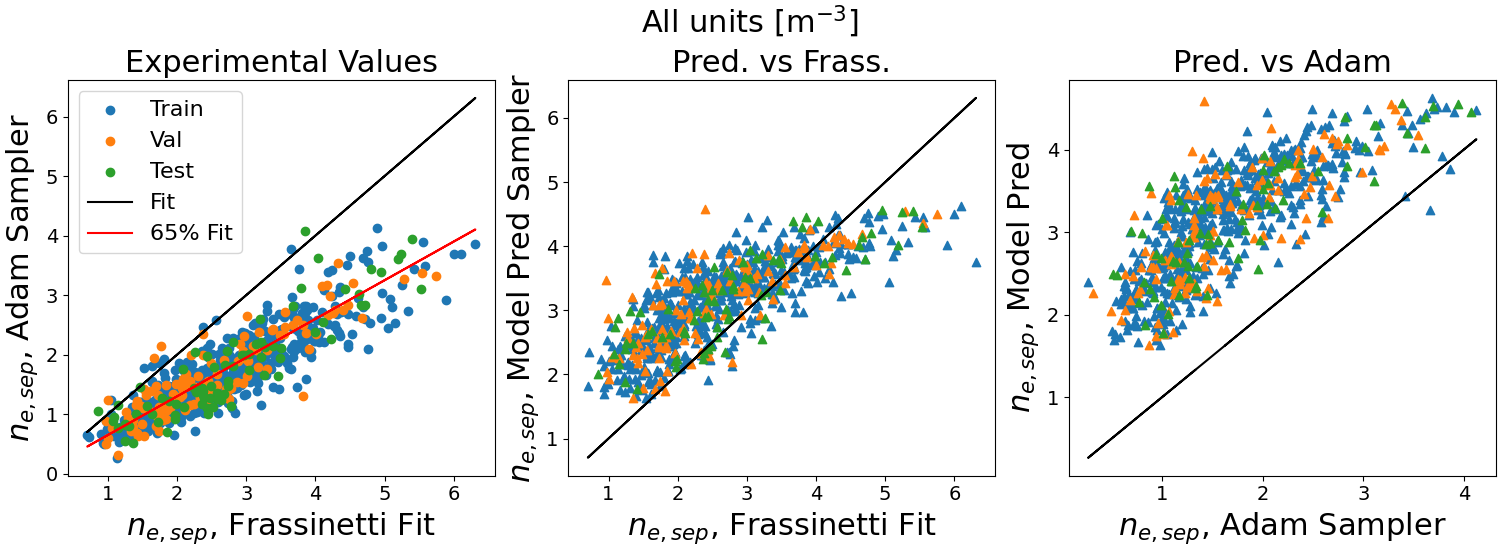

In [160]:
plt.close('all')

fig, axs = plt.subplots(1,3, figsize=(15, 5.5), constrained_layout=True)
axs[0].scatter(df_train['lor_exp'], df_train['mask'], label='Train')
axs[0].scatter(df_val['lor_exp'], df_val['mask'], label='Val')
axs[0].scatter(df_test['lor_exp'], df_test['mask'], label='Test')
axs[0].plot(df_train['lor_exp'], df_train['lor_exp'], color='black', label='Fit')
axs[0].plot(df_train['lor_exp'], 0.65*df_train['lor_exp'], color='red', label='65% Fit')

axs[1].scatter(df_train['lor_exp'], df_train['pred_mask'], marker='^', label='pred')
axs[1].scatter(df_val['lor_exp'], df_val['pred_mask'], marker='^')
axs[1].scatter(df_test['lor_exp'], df_test['pred_mask'], marker='^')
axs[1].plot(df_train['lor_exp'], df_train['lor_exp'], color='black')
axs[0].legend()



axs[2].scatter(df_train['mask'], df_train['pred_mask'], marker='^', label='pred')
axs[2].scatter(df_val['mask'], df_val['pred_mask'], marker='^')
axs[2].scatter(df_test['mask'], df_test['pred_mask'], marker='^')
axs[2].plot(df_train['mask'], df_train['mask'], color='black')

axs[0].set(xlabel='$n_{e, sep}$, Frassinetti Fit', ylabel='$n_{e, sep}$, Adam Sampler', title='Experimental Values')
axs[1].set(xlabel='$n_{e, sep}$, Frassinetti Fit', ylabel='$n_{e, sep}$, Model Pred Sampler', title='Pred. vs Frass.')
axs[2].set(xlabel='$n_{e, sep}$, Adam Sampler', ylabel='$n_{e, sep}$, Model Pred', title='Pred. vs Adam')
fig.suptitle('All units [m$^{-3}$]')
plt.show()


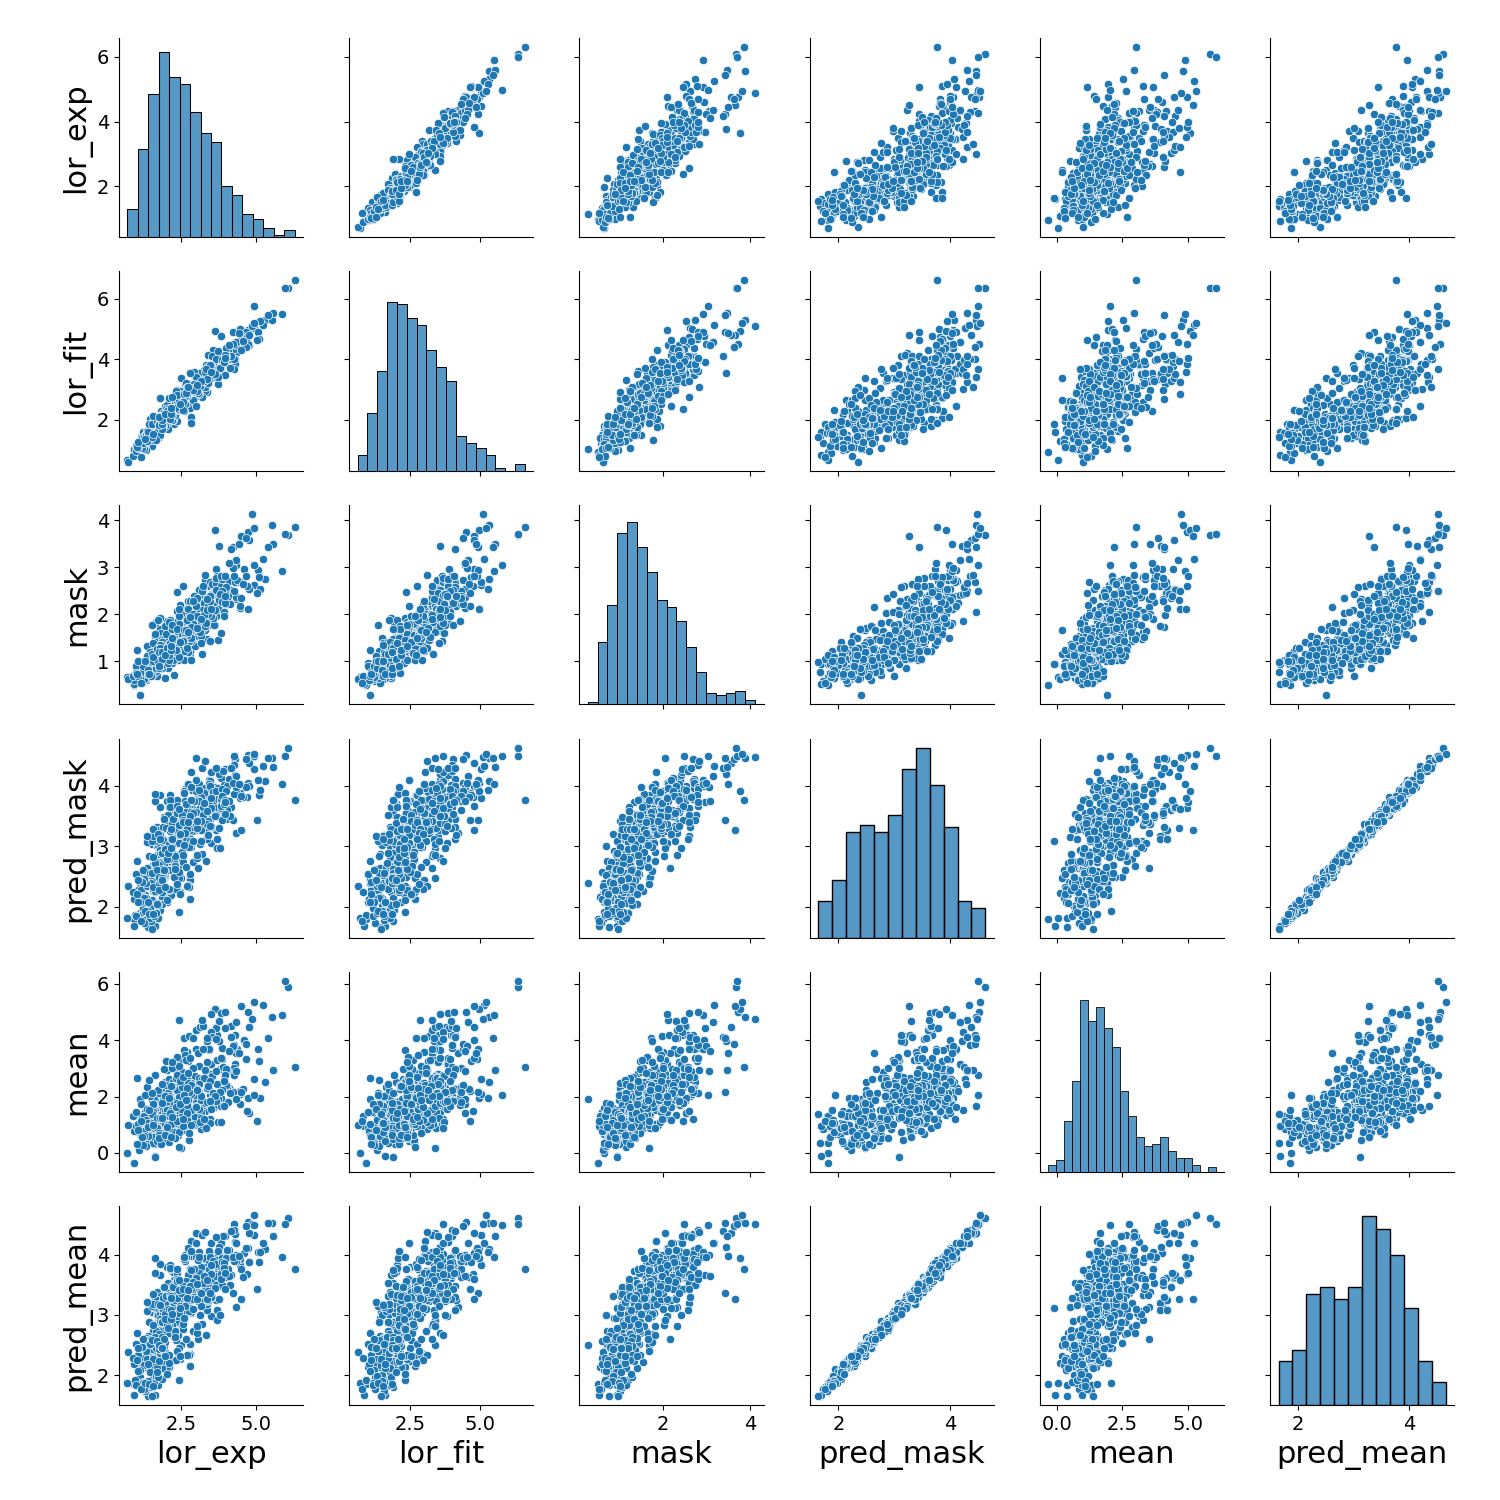

In [114]:
g = sns.PairGrid(df_train, )
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

2. Behaviour in variations of machine parameters
    - Linear in $I_P$
    - $P_{NBI}$ Small effects 
    - See Frassinetti 2020 for more details on waht to expect


In [ ]:
# Select a pulse, then vary the current
# This is probably a bad idea, as current will change many things, like q_cycl

# Select a few pulses that slowly increase in current and show the prediction between them. 
# Potential for current shots are 87474 (train), 92234 (test), 92439 (train) -> Can show if it picks up in the middle! 
idx_low_train = train_pulse_idxs[train_pulses.index(87474)]
idx_high_train = train_pulse_idxs[train_pulses.index(92439)]
idx_mid_test = test_pulse_idxs[test_pulses.index(92234)]

train_profiles_for_plot, train_mps_for_plot = train_profiles[idx_low_train + idx_high_train], train_mp_tensors[idx_low_train + idx_high_train]

idx_low = all_pulse_idxs[all_pulses.index(87474)]
idx_high = all_pulse_idxs[all_pulses.index(92439)]
idx_mid = all_pulse_idxs[all_pulses.index(92234)]

idxs_dict = {'low': {'idxs': idx_low, 'colors': ('aqua', 'cadetblue'), 'label': str(87474) + '(low) $I_P$'}, 
             'med': {'idxs': idx_mid, 'colors': ('crimson', 'pink'), 'label': str(92234)+ '(med) $I_P$'}, 
             'high': {'idxs': idx_high, 'colors': ('olivedrab', 'forestgreen'), 'label': str(92439)+ '(high) $I_P$'}}

plt.close('all')
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 5))
for name, idxs in idxs_dict.items(): 
    profiles_for_plot, mps_for_plot, masks_for_plot, psis_for_plot = all_profiles[idxs['idxs']], all_mp_tensors[idxs['idxs']], all_masks[idxs['idxs']], all_psis[idxs['idxs']]
    PULSE_sample = profiles_for_plot, psis_for_plot, masks_plot, None, mps_for_plot, None # profiles, psi, mask > 0, pulses, pulse_mps, rmid
    PULSE_conditional = conditional_inference_simple_mean(PULSE_sample, model_physics)
    d_profs_real, t_profs_real = pr ofiles_for_plot[:, 0, :], profiles_for_plot[:, 1, :]
    d_profs_con, t_profs_con = PULSE_conditional[:, 0, :], PULSE_conditional[:, 1, :]
    
    
    for n, (d_prof, t_prof, d_prof_real, t_prof_real, mask, psis) in enumerate(zip(d_profs_con, t_profs_con, d_profs_real, t_profs_real, masks_for_plot, psis_for_plot)):
        if n == 0: 
            label_real = idxs['label'] + ' Real'
            label_pred = idxs['label'] + ' Pred'
        else: 
            label_real, label_pred = None, None 

        axs[0].scatter(psis[mask], d_prof[mask], color=idxs['colors'][0], label=label_pred, zorder=10)
        axs[0].scatter(psis[mask], d_prof_real[mask], color=idxs['colors'][1], label=label_real, alpha=0.4)

        axs[1].scatter(psis[mask], t_prof[mask], color=idxs['colors'][0], label=label_pred, zorder=10)
        axs[1].scatter(psis[mask], t_prof_real[mask], color=idxs['colors'][1], label=label_real, alpha=0.4)

        axs[2].scatter(psis[mask], 1e-23*d_prof[mask]*t_prof[mask], color=idxs['colors'][0], label=label_pred, zorder=10)
        axs[2].scatter(psis[mask], 1e-23*d_prof_real[mask]*t_prof_real[mask], color=idxs['colors'][1], label=label_real, alpha=0.4)
        
axs[1].legend()
fig.suptitle('Profile changes in $I_P$')
    
axs[1].set_ylim(0, 1000)
plt.show()    

"""
mp_cols_jetpbd = ['B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity']
current_subset = PULSE_DF_SANDBOX[(PULSE_DF_SANDBOX['P_TOT=PNBI+Pohm+PICRH-Pshi(MW)'] < 13) & (PULSE_DF_SANDBOX['P_TOT=PNBI+Pohm+PICRH-Pshi(MW)'] > 10) & (PULSE_DF_SANDBOX['gasflowrateofmainspecies10^22(e/s)'] > 2)& (PULSE_DF_SANDBOX['gasflowrateofmainspecies10^22(e/s)'] < 3)& (PULSE_DF_SANDBOX['q95'] > 2.7) & (PULSE_DF_SANDBOX['q95'] < 3.5)& (PULSE_DF_SANDBOX['averagetriangularity'] < 0.27)] # & (PULSE_DF_SANDBOX['divertorconfiguration'] == 'C/C')

minima = min(current_subset['Ip(MA)'])
maxima = max(current_subset['Ip(MA)'])



norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)

plt.close('all')
fig = plt.figure()
plt.scatter(current_subset['nepedheight10^19(m^-3)'], current_subset['Tepedheight(keV)'], color=mapper.to_rgba(current_subset['Ip(MA)']))
fig.colorbar(mapper)
plt.xlim(2, 10)
plt.ylim(0, 1)
plt.show()
display(HTML(current_subset[['shot', 'nepedheight10^19(m^-3)'] + mp_cols_jetpbd].to_html()))
# PULSE_DF_SANDBOX['P_TOT=PNBI+Pohm+PICRH-Pshi(MW)']
"""


In [ ]:
## # PULSE_sample = train_profiles[idx_los_train + idx_high_train], pulse_psi[pulse_ids[k]], pulse_mask[pulse_ids[k]] > 0, pulses[k], pulse_mps[pulse_ids[k]], pulse_rmid[pulse_ids[k]]

# take the test profiles 
# propogate them both through conditional things 
# show profiles comparison 





# PULSE_DF_SANDBOX[['nepedheight10^19(m^-3)', 'Ip(MA)']].sort_values('Ip(MA)', ascending=True).tail(15)